In [65]:
import pandas as pd
import numpy as np
import datetime

from jpholiday import is_holiday
from utils import one_hot_encoder, PARK_POINT, PARKS

num_rows=10000

%matplotlib inline

In [8]:
# load datasets
train_df = pd.read_csv('../input/train.tsv', sep='\t')
test_df = pd.read_csv('../input/test.tsv', sep='\t')

colopl = pd.read_csv('../input/colopl.tsv', sep='\t')
hotlink = pd.read_csv('../input/hotlink.tsv', sep='\t')
nied_oyama = pd.read_csv('../input/nied_oyama.tsv', sep='\t')
nightley = pd.read_csv('../input/nightley.tsv', sep='\t')
weather = pd.read_csv('../input/weather.tsv', sep='\t')
jorudan = pd.read_csv('../input/jorudan.tsv', sep='\t', nrows=10000)
sub = pd.read_csv('../input/sample_submit.tsv', sep='\t', index_col=0, header=None)

In [10]:
test_df['visitors'] = np.nan
df = train_df.append(test_df[['datetime', 'park', 'visitors']]).reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
train_df

,datetime,park,visitors
0,2015-01-01,阿寒摩周国立公園,11028
1,2015-01-01,十和田八幡平国立公園,34757
2,2015-01-01,日光国立公園,29714
3,2015-01-01,伊勢志摩国立公園,42652
4,2015-01-01,大山隠岐国立公園,3637
5,2015-01-01,阿蘇くじゅう国立公園,1369
6,2015-01-01,霧島錦江湾国立公園,35352
7,2015-01-01,慶良間諸島国立公園,151
8,2015-01-02,阿寒摩周国立公園,11153
9,2015-01-02,十和田八幡平国立公園,33795


In [4]:
test_df

,index,datetime,park
0,0,2017-01-01,阿寒摩周国立公園
1,1,2017-01-01,十和田八幡平国立公園
2,2,2017-01-01,日光国立公園
3,3,2017-01-01,伊勢志摩国立公園
4,4,2017-01-01,大山隠岐国立公園
5,5,2017-01-01,阿蘇くじゅう国立公園
6,6,2017-01-01,霧島錦江湾国立公園
7,7,2017-01-01,慶良間諸島国立公園
8,8,2017-01-02,阿寒摩周国立公園
9,9,2017-01-02,十和田八幡平国立公園


In [5]:
colopl

,year,month,park,country_jp,count
0,2016,1,阿寒摩周国立公園,アメリカ合衆国,1-9
1,2016,1,阿寒摩周国立公園,シンガポール,1-9
2,2016,1,阿寒摩周国立公園,マレーシア,1-9
3,2016,1,阿寒摩周国立公園,中国,1-9
4,2016,1,阿寒摩周国立公園,台湾,19
5,2016,1,阿寒摩周国立公園,朝鮮、南部,1-9
6,2016,1,阿寒摩周国立公園,香港(PRC),12
7,2016,1,十和田八幡平国立公園,アメリカ合衆国,1-9
8,2016,1,十和田八幡平国立公園,オーストラリア,1-9
9,2016,1,十和田八幡平国立公園,ノルウェー,1-9


In [3]:
hotlink

,datetime,domain,keyword,count
0,2015-01-01,twitter_sampling,国立公園,148
1,2015-01-01,blog,アオウミガメ,11
2,2015-01-01,twitter_sampling,アオウミガメ,1
3,2015-01-01,bbs,阿波連岬園地,0
4,2015-01-01,blog,阿波連岬園地,0
5,2015-01-01,bbs,鬼怒川,2
6,2015-01-01,twitter_sampling,阿波連岬園地,0
7,2015-01-01,bbs,稲崎園地,0
8,2015-01-01,blog,稲崎園地,0
9,2015-01-01,twitter_sampling,稲崎園地,0


In [7]:
nied_oyama

,日時,積雪深(cm),積雪深重量(kg m^-2),気温(℃),降水量(mm h-1)
0,2015-01-01 00:00:00,99.3,305.1,-4.8,1.0
1,2015-01-01 01:00:00,101.9,308.3,-4.8,1.0
2,2015-01-01 02:00:00,102.5,310.3,-5.3,0.0
3,2015-01-01 03:00:00,101.8,310.6,-5.5,0.0
4,2015-01-01 04:00:00,101.9,311.1,-6.1,0.5
5,2015-01-01 05:00:00,102.7,311.5,-7.0,0.0
6,2015-01-01 06:00:00,105.2,313.7,-7.8,0.0
7,2015-01-01 07:00:00,105.5,314.5,-8.2,0.5
8,2015-01-01 08:00:00,105.8,315.4,-8.5,0.0
9,2015-01-01 09:00:00,105.4,315.0,-8.4,0.5


In [8]:
nightley

,datetime,Japan_count,Foreign_count
0,2016-01-01,28,0
1,2016-01-02,66,1
2,2016-01-03,75,6
3,2016-01-04,50,1
4,2016-01-05,25,0
5,2016-01-06,29,2
6,2016-01-07,7,1
7,2016-01-08,9,1
8,2016-01-09,43,2
9,2016-01-10,68,2


In [14]:
weather

,年月日,地点,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),10分間降水量の最大(mm),日照時間(時間),合計全天日射量(MJ/㎡),最深積雪(cm),...,最多風向(16方位),平均蒸気圧(hPa),平均現地気圧(hPa),平均湿度(%),平均海面気圧(hPa),最小相対湿度(%),最低海面気圧(hPa),平均雲量(10分比),天気概況(昼:06時~18時),天気概況(夜:18時~翌日06時)
0,2015/1/1,十和田,-1.9,0.3,-2.9,5.0,1.0,2.1,NaN,18.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015/1/2,十和田,-3.9,-1.1,-8.0,0.0,0.0,3.3,NaN,17.0,...,西北西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015/1/3,十和田,-4.0,-1.6,-8.9,2.0,0.5,1.4,NaN,21.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015/1/4,十和田,0.6,3.4,-1.6,0.0,0.0,2.6,NaN,19.0,...,南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015/1/5,十和田,0.8,5.4,-5.1,0.0,0.0,4.0,NaN,14.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015/1/6,十和田,2.0,7.9,-3.1,0.0,0.0,1.2,NaN,10.0,...,西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015/1/7,十和田,-3.7,-1.2,-5.5,0.0,0.0,4.2,NaN,11.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015/1/8,十和田,0.2,2.2,-1.4,0.0,0.0,1.8,NaN,9.0,...,西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015/1/9,十和田,-0.2,2.4,-3.9,0.5,0.5,2.3,NaN,13.0,...,西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015/1/10,十和田,-0.5,1.8,-2.1,0.0,0.0,4.7,NaN,10.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
sub

,1
0,
0,53822
1,48553
2,40052
3,1524
4,10759
5,57010
6,865
7,14603
8,35150


In [39]:
weather['地点'].value_counts()

十和田    1095
渡嘉敷    1095
日光     1095
大田     1095
釧路     1095
鹿児島    1095
大山     1095
熊本     1095
高森     1095
青森     1095
鹿角     1095
鳥羽     1095
Name: 地点, dtype: int64

In [100]:
#testのtargetをnanにしときます
test_df['visitors'] = np.nan

# merge
df = train_df.append(test_df[['datetime', 'park', 'visitors']]).reset_index()

In [101]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [102]:
df['day'] = df['datetime'].dt.day.astype(object)
df['month'] = df['datetime'].dt.month.astype(object)
df['weekday'] = df['datetime'].dt.weekday.astype(object)
df['weekofyear'] = df['datetime'].dt.weekofyear.astype(object)
df['day_month'] = df['day'].astype(str)+'_'+df['month'].astype(str)
df['day_weekday'] = df['day'].astype(str)+'_'+df['weekday'].astype(str)
df['day_weekofyear'] = df['day'].astype(str)+'_'+df['weekofyear'].astype(str)
df['month_weekday'] = df['month'].astype(str)+'_'+df['weekday'].astype(str)
df['month_weekofyear'] = df['month'].astype(str)+'_'+df['weekofyear'].astype(str)
df['weekday_weekofyear'] = df['weekday'].astype(str)+'_'+df['weekofyear'].astype(str)
df

,index,datetime,park,visitors,day,month,weekday,weekofyear,day_month,day_weekday,day_weekofyear,month_weekday,month_weekofyear,weekday_weekofyear
0,0,2015-01-01,阿寒摩周国立公園,11028.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
1,1,2015-01-01,十和田八幡平国立公園,34757.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
2,2,2015-01-01,日光国立公園,29714.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
3,3,2015-01-01,伊勢志摩国立公園,42652.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
4,4,2015-01-01,大山隠岐国立公園,3637.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
5,5,2015-01-01,阿蘇くじゅう国立公園,1369.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
6,6,2015-01-01,霧島錦江湾国立公園,35352.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
7,7,2015-01-01,慶良間諸島国立公園,151.0,1,1,3,1,1_1,1_3,1_1,1_3,1_1,3_1
8,8,2015-01-02,阿寒摩周国立公園,11153.0,2,1,4,1,2_1,2_4,2_1,1_4,1_1,4_1
9,9,2015-01-02,十和田八幡平国立公園,33795.0,2,1,4,1,2_1,2_4,2_1,1_4,1_1,4_1


In [103]:
df.dtypes

index                          int64
datetime              datetime64[ns]
park                          object
visitors                     float64
day                           object
month                         object
weekday                       object
weekofyear                    object
day_month                     object
day_weekday                   object
day_weekofyear                object
month_weekday                 object
month_weekofyear              object
weekday_weekofyear            object
dtype: object

In [104]:
df, cat_cols = one_hot_encoder(df, nan_as_category=False)

In [105]:
df

,index,datetime,visitors,park_伊勢志摩国立公園,park_十和田八幡平国立公園,park_大山隠岐国立公園,park_慶良間諸島国立公園,park_日光国立公園,park_阿寒摩周国立公園,park_阿蘇くじゅう国立公園,...,weekday_weekofyear_6_49,weekday_weekofyear_6_5,weekday_weekofyear_6_50,weekday_weekofyear_6_51,weekday_weekofyear_6_52,weekday_weekofyear_6_53,weekday_weekofyear_6_6,weekday_weekofyear_6_7,weekday_weekofyear_6_8,weekday_weekofyear_6_9
0,0,2015-01-01,11028.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2015-01-01,34757.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2015-01-01,29714.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2015-01-01,42652.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2015-01-01,3637.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,2015-01-01,1369.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,6,2015-01-01,35352.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,2015-01-01,151.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,2015-01-02,11153.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,9,2015-01-02,33795.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.columns

NameError: name 'df' is not defined

In [47]:
jorudan

,access_date,access_time,departure_and_arrival_type,departure_and_arrival_date,departure_and_arrival_time,departure_and_arrival_place_type,park,departure_prefecture,arrival_prefecture
0,2015-01-02,17:19:52,D,2015-01-03,06:44,D,日光国立公園,栃木県,神奈川
1,2015-01-02,15:16:57,A,2015-01-03,06:40,D,日光国立公園,栃木県,神奈川
2,2015-01-02,15:17:22,D,2015-01-03,06:40,D,日光国立公園,栃木県,神奈川
3,2015-01-02,15:35:05,D,2015-01-03,06:40,D,日光国立公園,栃木県,神奈川
4,2015-01-02,17:07:22,D,2015-01-03,07:57,D,日光国立公園,栃木県,神奈川
5,2015-01-02,17:18:15,D,2015-01-03,07:57,D,日光国立公園,栃木県,神奈川
6,2015-01-02,17:29:15,D,2015-01-03,06:44,D,日光国立公園,栃木県,神奈川
7,2015-01-05,22:16:14,A,2015-01-06,18:00,D,日光国立公園,栃木県,神奈川
8,2015-01-09,08:07:36,A,2015-01-21,10:35,D,日光国立公園,栃木県,神奈川
9,2015-01-10,11:24:53,D,2015-01-10,11:08,D,日光国立公園,栃木県,神奈川


In [46]:
nied_oyama['datetime'] = pd.DatetimeIndex(pd.to_datetime(nied_oyama['日時'])).normalize()
nied_oyama['park'] = '大山隠岐国立公園'
nied_oyama.groupby(['datetime', 'park']).mean()

,,積雪深(cm),積雪深重量(kg m^-2),気温(℃),降水量(mm h-1)
datetime,park,,,,
2015-01-01,大山隠岐国立公園,116.029167,327.050000,-6.895833,0.437500
2015-01-02,大山隠岐国立公園,137.983333,368.362500,-6.362500,0.270833
2015-01-03,大山隠岐国立公園,150.050000,403.212500,-3.400000,0.083333
2015-01-04,大山隠岐国立公園,137.358333,408.400000,0.166667,0.000000
2015-01-05,大山隠岐国立公園,126.766667,409.720833,1.812500,0.000000
2015-01-06,大山隠岐国立公園,116.237500,434.712500,1.945833,0.062500
2015-01-07,大山隠岐国立公園,113.716667,434.012500,-2.462500,0.166667
2015-01-08,大山隠岐国立公園,122.450000,446.629167,-3.033333,0.062500
2015-01-09,大山隠岐国立公園,128.420833,464.870833,-2.325000,0.104167


In [45]:
nied_oyama.dtypes

日時                        object
積雪深(cm)                  float64
積雪深重量(kg m^-2)           float64
気温(℃)                    float64
降水量(mm h-1)              float64
datetime          datetime64[ns]
dtype: object

In [15]:
weather[feats].groupby(['park', 'datetime']).mean()

平均気温(℃)  最高気温(℃)  最低気温(℃)  降水量の合計(mm)  10分間降水量の最大(mm)  \
park      datetime                                                            
伊勢志摩国立公園  2015-01-01      3.0      6.7     -0.2         0.0             0.0   
          2015-01-02      2.3      6.6     -1.9         0.0             0.0   
          2015-01-03      3.0      6.7     -1.4         0.0             0.0   
          2015-01-04      4.5     10.8     -1.7         0.0             0.0   
          2015-01-05      5.9     10.4      0.6         0.0             0.0   
          2015-01-06      6.9     10.9      3.1         6.5             1.0   
          2015-01-07      5.4      7.2      3.2         0.0             0.0   
          2015-01-08      4.6      6.4      2.8         0.0             0.0   
          2015-01-09      5.8      7.7      3.8         0.0             0.0   
          2015-01-10      5.9      8.0      4.7         0.0             0.0   
          2015-01-11      5.8     10.5     -1.2         0.0             0.0   
          2015-01-12      4.3      5.7      2.6         0.0             0.0   
          2015-01-13      5.7      8.5      3.2         0.0             0.0   
          2015-01-14      4.4      7.4     -0.7         0.0             0.0   
          2015-01-15      6.0      7.9      3.9        32.0             3.0   
          2015-01-16      6.7      9.7      2.6         0.5             0.5   
          2015-01-17      5.7      9.9      3.1         0.0             0.0   
          2015-01-18      4.8      7.9      2.6         0.0             0.0   
          2015-01-19      6.3     10.9      0.5         0.0             0.0   
          2015-01-20      6.4      9.1      3.6         0.0             0.0   
          2015-01-21      5.5      7.4      3.0         0.0             0.0   
          2015-01-22      7.3      9.7      5.3        40.0             2.0   
          2015-01-23      7.2      8.7      4.6         0.0             0.0   
          2015-01-24      5.9      9.7      2.3         0.0             0.0   
          2015-01-25      6.8     10.8      3.4         0.0             0.0   
          2015-01-26      5.7      8.2      1.9        12.5             1.0   
          2015-01-27      9.3     13.6      4.8        16.5             2.0   
          2015-01-28      3.9      5.6      1.3         0.0             0.0   
          2015-01-29      3.3      5.7      0.1         0.0             0.0   
          2015-01-30      4.3      6.2      2.3        12.5             1.0   
...                       ...      ...      ...         ...             ...   
霧島錦江湾国立公園 2017-12-01     10.4     14.6      6.4         0.0             0.0   
          2017-12-02     10.5     14.5      5.4         0.0             0.0   
          2017-12-03     14.9     18.9     11.7         0.0             0.0   
          2017-12-04     13.9     17.0     10.3         0.0             0.0   
          2017-12-05      7.9     11.1      5.4         0.0             0.0   
          2017-12-06      7.8     12.5      4.4         0.0             0.0   
          2017-12-07      9.7     14.5      3.7         0.5             0.5   
          2017-12-08      8.4     10.9      5.2         3.0             0.5   
          2017-12-09      7.9     12.4      4.3         0.0             0.0   
          2017-12-10      8.4     11.2      4.2         3.5             1.0   
          2017-12-11      9.2     12.6      6.3         0.0             0.0   
          2017-12-12      6.7      9.1      4.9         0.0             0.0   
          2017-12-13      5.8     11.4      2.7         0.0             0.0   
          2017-12-14      7.4     12.9      1.6         0.0             0.0   
          2017-12-15     10.2     13.3      8.3         0.0             0.0   
          2017-12-16      9.1     12.3      4.7         1.0             0.5   
          2017-12-17      5.7      9.2      3.9         0.0             0.0   
          2017-12-18      6.5     11.4      2.4         0.0             

In [17]:
pd.merge(df, weather, on=['datetime', 'park'], how='outer')

,index,datetime,park,visitors,年月日,地点,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),...,最多風向(16方位),平均蒸気圧(hPa),平均現地気圧(hPa),平均湿度(%),平均海面気圧(hPa),最小相対湿度(%),最低海面気圧(hPa),平均雲量(10分比),天気概況(昼:06時~18時),天気概況(夜:18時~翌日06時)
0,0,2015-01-01,阿寒摩周国立公園,11028.0,2015/1/1,釧路,-5.0,-2.6,-8.7,0.0,...,北北東,3.0,994.6,71.0,999.6,56.0,996.9,5.3,曇後晴,晴
1,1,2015-01-01,十和田八幡平国立公園,34757.0,2015/1/1,十和田,-1.9,0.3,-2.9,5.0,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2015-01-01,十和田八幡平国立公園,34757.0,2015/1/1,青森,-1.3,1.0,-2.7,15.0,...,南西,4.9,999.8,88.0,1000.3,71.0,997.6,9.5,雪、あられを伴う,雪
3,1,2015-01-01,十和田八幡平国立公園,34757.0,2015/1/1,鹿角,-2.9,-1.4,-5.6,2.5,...,西南西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,2015-01-01,日光国立公園,29714.0,2015/1/1,日光,-7.4,-2.7,-9.7,0.0,...,西南西,2.1,852.5,61.0,NaN,41.0,NaN,NaN,NaN,NaN
5,3,2015-01-01,伊勢志摩国立公園,42652.0,2015/1/1,鳥羽,3.0,6.7,-0.2,0.0,...,西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4,2015-01-01,大山隠岐国立公園,3637.0,2015/1/1,大山,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4,2015-01-01,大山隠岐国立公園,3637.0,2015/1/1,大田,1.1,5.0,-1.5,7.5,...,西北西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5,2015-01-01,阿蘇くじゅう国立公園,1369.0,2015/1/1,熊本,2.2,5.9,-1.3,0.0,...,西北西,4.0,1015.6,56.0,1020.6,36.0,1017.8,5.0,晴時々雪一時曇,晴後一時雪
9,5,2015-01-01,阿蘇くじゅう国立公園,1369.0,2015/1/1,高森,-2.6,0.8,-5.2,0.0,...,西北西,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
pd.merge(df, nightley, on='datetime', how='outer')
#df = df.join(nightley, how='left', on='datetime')

,index,datetime,park,visitors,Japan_count,Foreign_count
0,0,2015-01-01,阿寒摩周国立公園,11028.0,NaN,NaN
1,1,2015-01-01,十和田八幡平国立公園,34757.0,NaN,NaN
2,2,2015-01-01,日光国立公園,29714.0,NaN,NaN
3,3,2015-01-01,伊勢志摩国立公園,42652.0,NaN,NaN
4,4,2015-01-01,大山隠岐国立公園,3637.0,NaN,NaN
5,5,2015-01-01,阿蘇くじゅう国立公園,1369.0,NaN,NaN
6,6,2015-01-01,霧島錦江湾国立公園,35352.0,NaN,NaN
7,7,2015-01-01,慶良間諸島国立公園,151.0,NaN,NaN
8,8,2015-01-02,阿寒摩周国立公園,11153.0,NaN,NaN
9,9,2015-01-02,十和田八幡平国立公園,33795.0,NaN,NaN


In [31]:
df

,index,datetime,park,visitors
0,0,2015-01-01,阿寒摩周国立公園,11028.0
1,1,2015-01-01,十和田八幡平国立公園,34757.0
2,2,2015-01-01,日光国立公園,29714.0
3,3,2015-01-01,伊勢志摩国立公園,42652.0
4,4,2015-01-01,大山隠岐国立公園,3637.0
5,5,2015-01-01,阿蘇くじゅう国立公園,1369.0
6,6,2015-01-01,霧島錦江湾国立公園,35352.0
7,7,2015-01-01,慶良間諸島国立公園,151.0
8,8,2015-01-02,阿寒摩周国立公園,11153.0
9,9,2015-01-02,十和田八幡平国立公園,33795.0


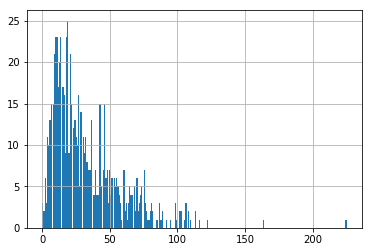

In [26]:
nightley.Japan_count.hist(bins=255)

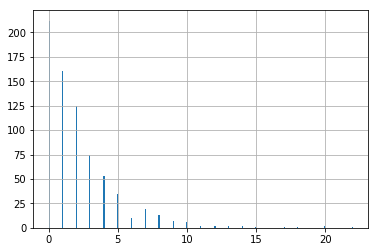

In [27]:
nightley.Foreign_count.hist(bins=255)

In [28]:
nightley.Foreign_count / nightley.Japan_count

0      0.000000
1      0.015152
2      0.080000
3      0.020000
4      0.000000
5      0.068966
6      0.142857
7      0.111111
8      0.046512
9      0.029412
10     0.054054
11     0.052632
12     0.083333
13     0.000000
14     0.000000
15     0.000000
16     0.045455
17     0.250000
18     0.000000
19     0.000000
20     0.000000
21     0.538462
22     0.031250
23     0.078431
24     0.500000
25     0.000000
26     0.000000
27     0.250000
28     0.611111
29     0.122449
         ...   
700    0.214286
701    0.000000
702    0.013158
703    0.166667
704    0.111111
705    0.111111
706    0.000000
707    0.000000
708    0.017857
709    0.042857
710    0.000000
711    0.555556
712    0.200000
713    0.250000
714    0.230769
715    0.000000
716    0.128205
717    0.080000
718    0.200000
719    0.100000
720    0.200000
721    0.095238
722    0.022989
723    0.108696
724    0.214286
725    0.062500
726    0.105263
727    0.181818
728    0.088889
729    0.000000
Length: 730, dtype: floa

In [28]:
for park in PARKS.keys():
    print(park)

霧島錦江湾国立公園
十和田八幡平国立公園
日光国立公園
伊勢志摩国立公園
阿蘇くじゅう国立公園
大山隠岐国立公園
阿寒摩周国立公園
慶良間諸島国立公園


In [31]:
weather[weather['park']=='霧島錦江湾国立公園'].shift()

,年月日,地点,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),10分間降水量の最大(mm),日照時間(時間),合計全天日射量(MJ/㎡),最深積雪(cm),...,平均現地気圧(hPa),平均湿度(%),平均海面気圧(hPa),最小相対湿度(%),最低海面気圧(hPa),平均雲量(10分比),天気概況(昼:06時~18時),天気概況(夜:18時~翌日06時),park,datetime
10950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
10951,2015/1/1,鹿児島,3.9,8.2,1.6,3.0,0.5,0.4,4.38,0.0,...,1016.0,74.0,1019.9,42.0,1016.8,9.3,雨時々雪一時晴、あられを伴う,曇時々晴一時雪,霧島錦江湾国立公園,2015-01-01
10952,2015/1/2,鹿児島,4.3,6.9,1.6,4.0,1.0,1.2,5.50,0.0,...,1018.8,79.0,1022.8,68.0,1021.1,9.0,雨一時雪、みぞれを伴う,晴一時雨,霧島錦江湾国立公園,2015-01-02
10953,2015/1/3,鹿児島,5.4,11.3,0.6,0.0,0.0,6.5,9.32,0.0,...,1019.9,74.0,1023.8,51.0,1021.4,6.3,曇時々晴,晴,霧島錦江湾国立公園,2015-01-03
10954,2015/1/4,鹿児島,9.4,16.5,3.5,0.0,0.0,5.1,8.61,0.0,...,1015.5,77.0,1019.4,50.0,1017.6,5.0,晴時々曇,晴,霧島錦江湾国立公園,2015-01-04
10955,2015/1/5,鹿児島,11.0,16.2,6.1,0.0,0.0,5.6,9.63,0.0,...,1015.2,79.0,1019.1,48.0,1016.2,7.5,曇一時晴,曇後一時雨,霧島錦江湾国立公園,2015-01-05
10956,2015/1/6,鹿児島,12.5,17.8,7.7,5.0,1.0,1.3,2.12,0.0,...,1007.4,79.0,1011.2,59.0,1008.7,6.3,雨時々曇,快晴,霧島錦江湾国立公園,2015-01-06
10957,2015/1/7,鹿児島,7.9,13.2,4.4,0.0,0.0,6.2,9.58,0.0,...,1011.8,65.0,1015.7,47.0,1012.6,2.8,晴後一時曇,晴,霧島錦江湾国立公園,2015-01-07
10958,2015/1/8,鹿児島,6.2,10.7,3.7,0.0,0.0,3.8,8.24,0.0,...,1017.7,59.0,1021.6,48.0,1019.0,3.5,曇後晴,快晴,霧島錦江湾国立公園,2015-01-08
10959,2015/1/9,鹿児島,6.9,12.9,1.9,0.0,0.0,8.0,12.27,0.0,...,1018.9,65.0,1022.9,42.0,1021.0,1.8,晴,晴,霧島錦江湾国立公園,2015-01-09


In [49]:
train_df.groupby('park').max()

,datetime,visitors
park,,
伊勢志摩国立公園,2016-12-31,87008
十和田八幡平国立公園,2016-12-31,45186
大山隠岐国立公園,2016-12-31,4943
慶良間諸島国立公園,2016-12-31,1691
日光国立公園,2016-12-31,57547
阿寒摩周国立公園,2016-12-31,20024
阿蘇くじゅう国立公園,2016-12-31,2037
霧島錦江湾国立公園,2016-12-31,50854


In [63]:
hotlink.domain.value_counts()

bbs                 48180
twitter_sampling    48180
blog                48180
Name: domain, dtype: int64

In [66]:
df['japanese_holiday'] = df['datetime'].dt.date.apply(is_holiday).astype(int)

In [80]:
df.groupby('datetime')['japanese_holiday'].mean()

datetime
2015-01-01    1
2015-01-02    0
2015-01-03    1
2015-01-04    1
2015-01-05    0
2015-01-06    0
2015-01-07    0
2015-01-08    0
2015-01-09    0
2015-01-10    1
2015-01-11    1
2015-01-12    1
2015-01-13    0
2015-01-14    0
2015-01-15    0
2015-01-16    0
2015-01-17    1
2015-01-18    1
2015-01-19    0
2015-01-20    0
2015-01-21    0
2015-01-22    0
2015-01-23    0
2015-01-24    1
2015-01-25    1
2015-01-26    0
2015-01-27    0
2015-01-28    0
2015-01-29    0
2015-01-30    0
             ..
2017-12-02    1
2017-12-03    1
2017-12-04    0
2017-12-05    0
2017-12-06    0
2017-12-07    0
2017-12-08    0
2017-12-09    1
2017-12-10    1
2017-12-11    0
2017-12-12    0
2017-12-13    0
2017-12-14    0
2017-12-15    0
2017-12-16    1
2017-12-17    1
2017-12-18    0
2017-12-19    0
2017-12-20    0
2017-12-21    0
2017-12-22    0
2017-12-23    2
2017-12-24    1
2017-12-25    0
2017-12-26    0
2017-12-27    0
2017-12-28    0
2017-12-29    0
2017-12-30    1
2017-12-31    1
Name: japanese_

In [78]:
df['japanese_holiday'] +=(df['datetime'].dt.weekday==5).astype(int)
df['japanese_holiday'] +=(df['datetime'].dt.weekday==6).astype(int)

In [79]:
df.groupby('datetime')['japanese_holiday'].mean()

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
8738    0
8739    0
8740    0
8741    0
8742    0
8743    0
8744    0
8745    0
8746    0
8747    0
8748    0
8749    0
8750    0
8751    0
8752    1
8753    1
8754    1
8755    1
8756    1
8757    1
8758    1
8759    1
8760    1
8761    1
8762    1
8763    1
8764    1
8765    1
8766    1
8767    1
Name: japanese_holiday, Length: 8768, dtype: int64